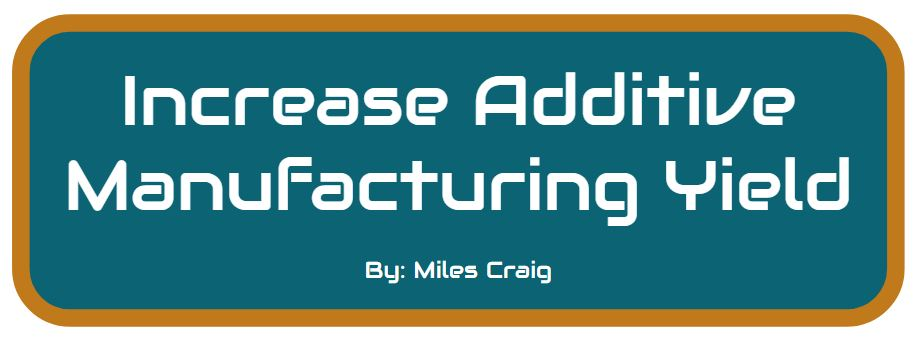

In [1212]:
from IPython.display import Image
Image(filename='images/import/title_pic.jpg')

In [1213]:
# Import Python Packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os # for reading csv files
import glob # for reading csv files
import re # to search strings for nums

In [1214]:
# Constants

colors = {'blue':'#0b6374', 'orange':'#c0791b', 'gray':'#666666'}
tt_fs = 20 # plot title font size

In [1215]:
# Read Print Parameters (PP), Run Log, and Porosity

# These are the Print Parameters used to print the part
pp = pd.read_csv('data/raw/pp/print_parameters.csv', index_col=0)
print('PRINT PARAMETERS')
print(pp)

print('----- ----- ----- ----- ----- ----- ----- ----- ----- -----')

# Read the Run logs collected during the print
runs = pd.read_csv('data/raw/runs/runs.csv', index_col=0)
runs['Date'] = pd.to_datetime(runs['Date'])
print('RUNS')
print(runs.head())

print('----- ----- ----- ----- ----- ----- ----- ----- ----- -----')

# Read Porosity file
# Technically Nov. 14/15, 2017 data
porosity = pd.read_csv('data/raw/mp/porosity.csv', index_col=0)
print('POROSITY')
print(porosity)

PRINT PARAMETERS
           Laser Power (W)  Scan Speed (mm/s)  Hatch Spacing (mm) Category
Condition                                                                 
1                      325               1650                0.09       PV
2                      300               1650                0.09       PV
3                      275               1650                0.09       PV
4                      180               1650                0.09       PV
5                      120               1650                0.09       PV
6                      370               3780                0.14       SV
7                      370               3000                0.14       SV
8                      370               2200                0.14       SV
9                      370               1320                0.14       SV
10                     370                880                0.14       SV
----- ----- ----- ----- ----- ----- ----- ----- ----- -----
RUNS
          Date  Co

In [1216]:
# Calculate GED in pp df

# Calculate GED
pp['GED'] = (pp['Laser Power (W)'] / \
    (pp['Scan Speed (mm/s)'] * pp['Hatch Spacing (mm)'])).round(2) # Calculate GED = LP/(SS*HS)

# Reorder PP columns Category and GED
pp_col = list(pp) # get PP column labels into a list
pp_col[3], pp_col[4] = pp_col[4], pp_col[3] # reorder column labels 3 & 4 in the list
pp = pp[pp_col] # reorder columns 3 & 4 in the dataframe

print('PRINT PARAMETERS')
print(pp)

PRINT PARAMETERS
           Laser Power (W)  Scan Speed (mm/s)  Hatch Spacing (mm)   GED  \
Condition                                                                 
1                      325               1650                0.09  2.19   
2                      300               1650                0.09  2.02   
3                      275               1650                0.09  1.85   
4                      180               1650                0.09  1.21   
5                      120               1650                0.09  0.81   
6                      370               3780                0.14  0.70   
7                      370               3000                0.14  0.88   
8                      370               2200                0.14  1.20   
9                      370               1320                0.14  2.00   
10                     370                880                0.14  3.00   

          Category  
Condition           
1               PV  
2               PV 

Text(2400,350,'370W')

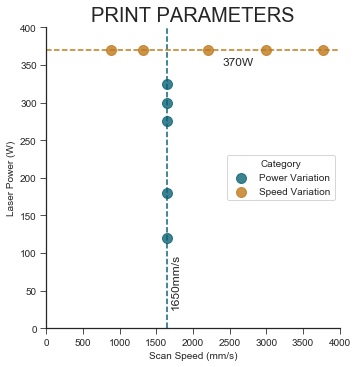

In [1217]:
# Create a plot of Print Parameters

pp_colors = {'PV':colors.get('blue'), 'SV':colors.get('orange')}

sns.set_style("ticks")

sns.lmplot('Scan Speed (mm/s)', # Horizontal Axis
           'Laser Power (W)', # Vertical Axis
           data=pp, # Data Source
           hue='Category', # Color Markers by
           palette=pp_colors, # Color Dictionary
           scatter_kws={'s': 100}, # Set Marker Size
           fit_reg=False, # Don't Fix a Regression Line
           legend=False # Remove Default Legend
          )

plt.title('PRINT PARAMETERS', fontsize=tt_fs)
plt.xlim(0, 4000)
plt.ylim(0, 400)
plt.legend(['Power Variation','Speed Variation'], title='Category', loc='right', frameon=True)

# add vertical constant line for power with label
plt.axvline(x=1650, color=pp_colors.get('PV'), linestyle='dashed')
plt.text(1700, 90, '1650mm/s', fontsize=12, rotation=90)

# add horizontal constant line for speed with label
plt.axhline(y=370, color=pp_colors.get('SV'), linestyle='dashed')
plt.text(2400, 350, '370W', fontsize=12)

#plt.savefig('pp.jpeg', dpi=1000, bbox_inches="tight")

In [1218]:
# Loop through and Read MPM files, name them, and create df's (Dictionary)

mpm_0 = {}
path = r'data/raw/mpm/data'
all_files = glob.glob(os.path.join(path, "*.csv"))
for f in all_files:
    file_nums = list(map(int, re.findall('\d+', f))) # search for #s in file name
    if 'viz' in f:
        vt = 'v'
    elif 'thresh' in f:
        vt = 't'
    df_name_0 = 'Runs_%d-%d_%s' % (file_nums[1], file_nums[2], vt) # name df 
    mpm_0[df_name_0] = pd.read_csv(f, header=None) # add df name to dict, read and add df as the value to the dict
    
viz_col = list(pd.read_csv('data/raw/mpm/cols/frames_viz_cols.csv', header=None).values.T.flatten()) # viz col headers
thresh_col = list(pd.read_csv('data/raw/mpm/cols/frames_thresh_cols.csv', header=None).values.T.flatten()) # thresh col headers
    
print(mpm_0.keys())

dict_keys(['Runs_16-19_t', 'Runs_16-19_v', 'Runs_20-22_t', 'Runs_20-22_v', 'Runs_23-25_t', 'Runs_23-25_v', 'Runs_26-28_t', 'Runs_26-28_v', 'Runs_29-31_t', 'Runs_29-31_v', 'Runs_32-34_t', 'Runs_32-34_v', 'Runs_35-37_t', 'Runs_35-37_v', 'Runs_38-40_t', 'Runs_38-40_v', 'Runs_41-43_t', 'Runs_41-43_v', 'Runs_44-45_t', 'Runs_44-45_v'])


In [1219]:
# function to wrangle mpm_v dfs
# name columns
# normalize intensities
# rename columns with counts/ms instead of counts
# convert '012' scan direction into 'cxy'

scan_direct = {0:'c',1:'x',2:'y'} # 0=c=contour, 1=x=X-axis, 2=y=Y-axis

def setup_v_df(df):
    df.columns = viz_col # add column labels
    # Normalize every intensity column by dividing counts by time (counts/ms)
    count_col = [col for col in df.columns if 'counts' in col] # create a list of all columns that have the units 'counts'
    df[count_col] = df[count_col].apply(lambda a: a / df['exp_time(ms)']) # normalize using exposure time (intensity / exp_time)
    df[count_col] = df[count_col].astype(int) # convert float to int
    viz_col_n = [w.replace('counts', 'counts/ms') for w in viz_col] # replace counts with counts/ms in column label
    df.columns = viz_col_n # apply updated column labels
    df['scan_direction(012)'].replace(scan_direct, inplace=True) # convert '012' scan direction into 'cxy'
    df.rename(columns={'scan_direction(012)':'scan_direction(cxy)'}, inplace=True) # replace '012' with 'cxy' in column label

In [1220]:
# function to wrangle mpm_t dfs
# name columns

def setup_t_df(df):
    df.columns = thresh_col # add column labels

In [1221]:
# apply functions to wrangle mpm dfs

for x in list(mpm_0.keys()):
    if 'v' in x:
        setup_v_df(mpm_0.get(x))
    elif 't' in x:
        setup_t_df(mpm_0.get(x))

print(mpm_0.get('Runs_16-19_v').head())
print('----- ----- ----- ----- ----- ----- ----- ----- ----- -----')
print(mpm_0.get('Runs_16-19_t').head())

   run_num  frame_num  time(s)  exp_time(ms)  int_s_p(counts/ms)  \
0       16         51    0.064      0.024957              111712   
1       16         52    0.065      0.024957              118964   
2       16         53    0.066      0.024957              127619   
3       16         54    0.068      0.024957              127138   
4       16         55    0.069      0.024957              126177   

   int_l_p(counts/ms)  int_s_avg_3(counts/ms)  int_l_avg_3(counts/ms)  \
0               61425                   80542                   43009   
1               63268                   79697                   47197   
2               68878                   90547                   48840   
3               71442                   91701                   55122   
4               76171                   99298                   48844   

   int_s_avg_5(counts/ms)  int_l_avg_5(counts/ms)  \
0                   53528                   29562   
1                   49673                   31

In [1222]:
# Combine v & t dfs per condition
# Technically this creates a df per condition so mpm_runs_##-## can become mpm_cond_##
# That is assuming that the runs using the same condition can be combined and analyzed as one
# Runs in the same condition have different windows

mpm_1 = {}
for x in list(mpm_0.keys()):
    if 'v' in x: # so that I don't combine v with t AND t with v
        df_name_nums_v = list(map(int, re.findall('\d+', x))) # search for #s in df name
        for y in list(mpm_0.keys()):
            df_name_nums_t = list(map(int, re.findall('\d+', y))) # search for #s in df name
            if df_name_nums_v == df_name_nums_t and 't' in y:
                combine_name = 'mpm_runs_%d-%d' % (df_name_nums_v[0], df_name_nums_v[1]) # name df
                mpm_0.get(y).drop(['run_num', 'frame_num'], axis=1, inplace=True) # duplicate columns between v and t
                mpm_1[combine_name] = pd.concat([mpm_0.get(x), mpm_0.get(y)], axis=1) # join 'v' and 't' and add to dict

print(mpm_1.get('mpm_runs_16-19').head())
print(mpm_1.keys())

   run_num  frame_num  time(s)  exp_time(ms)  int_s_p(counts/ms)  \
0       16         51    0.064      0.024957              111712   
1       16         52    0.065      0.024957              118964   
2       16         53    0.066      0.024957              127619   
3       16         54    0.068      0.024957              127138   
4       16         55    0.069      0.024957              126177   

   int_l_p(counts/ms)  int_s_avg_3(counts/ms)  int_l_avg_3(counts/ms)  \
0               61425                   80542                   43009   
1               63268                   79697                   47197   
2               68878                   90547                   48840   
3               71442                   91701                   55122   
4               76171                   99298                   48844   

   int_s_avg_5(counts/ms)  int_l_avg_5(counts/ms)          ...           \
0                   53528                   29562          ...            
1 

In [1223]:
# Split mpms into individual dfs per run
# May not be necessary because all runs per condition can be analyzed as one

mpm_2 = {}
for x in list(mpm_1.keys()):
    df_name_nums_1 = list(map(int, re.findall('\d+', x))) # search for #s in file name
    df_name_nums_1 = range(df_name_nums_1[0], df_name_nums_1[-1]+1) # create a list of #s in the range 'Runs_x-y'
    for y in df_name_nums_1:
        df_name_1 = 'mpm_run_%d' % (y) # name df per run
        mpm_2[df_name_1] = mpm_1.get(x)[mpm_1.get(x)['run_num'] == y] #split df per run
print(mpm_2.get('mpm_run_16').head())
print(mpm_2.keys())

   run_num  frame_num  time(s)  exp_time(ms)  int_s_p(counts/ms)  \
0       16         51    0.064      0.024957              111712   
1       16         52    0.065      0.024957              118964   
2       16         53    0.066      0.024957              127619   
3       16         54    0.068      0.024957              127138   
4       16         55    0.069      0.024957              126177   

   int_l_p(counts/ms)  int_s_avg_3(counts/ms)  int_l_avg_3(counts/ms)  \
0               61425                   80542                   43009   
1               63268                   79697                   47197   
2               68878                   90547                   48840   
3               71442                   91701                   55122   
4               76171                   99298                   48844   

   int_s_avg_5(counts/ms)  int_l_avg_5(counts/ms)          ...           \
0                   53528                   29562          ...            
1 

In [1224]:
# Match runs to conditions and create dict
# Use runs df cols Run/index and Condition to map mpm_2.keys() to a condition # and create a new dict

match_mpm_cond = {}
for x in list(mpm_2.keys()):
    df_name_num = list(map(int, re.findall('\d+', x)))[0]
    cond_num = runs.loc[df_name_num,['Condition']].iloc[0]
    match_mpm_cond[x] = cond_num

print(match_mpm_cond)

{'mpm_run_16': 1, 'mpm_run_17': 1, 'mpm_run_18': 1, 'mpm_run_19': 1, 'mpm_run_20': 2, 'mpm_run_21': 2, 'mpm_run_22': 2, 'mpm_run_23': 3, 'mpm_run_24': 3, 'mpm_run_25': 3, 'mpm_run_26': 4, 'mpm_run_27': 4, 'mpm_run_28': 4, 'mpm_run_29': 5, 'mpm_run_30': 5, 'mpm_run_31': 5, 'mpm_run_32': 6, 'mpm_run_33': 6, 'mpm_run_34': 6, 'mpm_run_35': 7, 'mpm_run_36': 7, 'mpm_run_37': 7, 'mpm_run_38': 8, 'mpm_run_39': 8, 'mpm_run_40': 8, 'mpm_run_41': 9, 'mpm_run_42': 9, 'mpm_run_43': 9, 'mpm_run_44': 10, 'mpm_run_45': 10}


In [1225]:
#Combine mpm_run_## into mpm_cond_##


mpm_3 = {} # going to be the latest dictionary for mpm dfs


for x in list(mpm_2.keys()):
    
    if x not in mpm_2:
        continue # because the keys in mpm_2 are deleted after being compared, 'continue' bypasses the ones already compared
    
    x_num = list(map(int, re.findall('\d+', x)))[0] # search for num in df_x name
    cond_num = match_mpm_cond[x] # find the condition num for df_x
    cond_name = 'mpm_cond_' + str(cond_num) # name given to the mpm_3 dictionary per each condition
    cond_list = [] # list for all of the runs to be combined per condition
    temp_df = mpm_2.get(x) # adds x to a temp df to later be combined with other runs of the same condition
    
    for y in list(mpm_2.keys()):
        y_num = list(map(int, re.findall('\d+', y)))[0] # search for num in df_y name
        cond_same = True if cond_num == match_mpm_cond[y] else False # if the conditions for x and y are the same, then True
        if x_num != y_num and cond_same:
            cond_list.append(y) # add y to the list
    
    for z in cond_list: # runs through the list of runs to be combined
            temp_df = pd.concat([temp_df, mpm_2.get(z)]) # adds the run to the df
            
    mpm_3[cond_name] = temp_df # adds the combined df to a dictionary with the key for the condition
    
    # delete combined dfs (x and cond_list)
    mpm_2.pop(x,None)
    for a in cond_list:
        mpm_2.pop(a,None)
    
print(mpm_3.keys())


dict_keys(['mpm_cond_1', 'mpm_cond_2', 'mpm_cond_3', 'mpm_cond_4', 'mpm_cond_5', 'mpm_cond_6', 'mpm_cond_7', 'mpm_cond_8', 'mpm_cond_9', 'mpm_cond_10'])
